In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
from copy import copy

In [2]:
P = 32

In [3]:
def Get_ADJ(file_path):
    F = pd.read_csv(file_path, delimiter = ' ', header = None)
    return (F.values).astype('float32')

def Get_Static_Table(file_path):
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        seq = []
        for ele in line[2:]:
            seq.append((int)(ele))
            
        Table[((int)(l),(int)(r))] = seq
    
    F.close()
    
    return Table

In [4]:
Target_Topology = '32k4torus'

Adj = Get_ADJ('../Simulator/topology/%s.adj'%Target_Topology)
SRTable = Get_Static_Table('../Simulator/topology/%s_Static.srt'%Target_Topology)

In [5]:
I_P = np.identity(P)

In [6]:
def smoothstep(x):
    R,C = x.shape
    for r in range(R):
        for c in range(C):
            if x[c][r] > 1:
                x[c][r] = 1
                
def Generate_RouteTree(A_now, D_now):
    global I_P
    D_next = np.matmul(I_P+Adj,D_now)
    smoothstep(D_next)
    return A_now, D_next

In [7]:
A = copy(Adj)
step = 0
D = np.identity(P)
Routines = []
DIST_M = np.zeros([P,P],dtype='int16')
while (np.min(D) == 0):
    A,D_N = Generate_RouteTree(A,D)
    Routines.append(np.transpose(D_N - D))
    step += 1
    DIST_M += step*(D_N - D).astype('int16')
    D = D_N

In [8]:
def get_BAMMA(filepath, rank_map = None):
    global P
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
    
    Algorithm = {}
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        if line[0][0] == '@':         # @ node
            rank = rank_map[(int)(line[0][1:])]
            Algorithm[rank] = []   # add node
            i = 1
            while i < len(line):
                if line[i] == 'C': # Compute
                    Vol = (int)(line[i+1])*\
                          (int)(line[i+2])*\
                          (int)(line[i+3])
                    Algorithm[rank].append(('C',Vol))
                    i += 3
                elif line[i] == 'S': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('S',rank_map[(int)(line[i+1])],Area))
                    i += 3
                elif line[i] == 'R': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('R',rank_map[(int)(line[i+1])],Area))
                    i += 3
                    
                    
                i += 1
    F.close()            
    return Algorithm

In [9]:
def Extract_cycles(filepath, rank_map = None):
    global P
    
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
        
    Ideal = np.zeros([P,P],dtype='int16')
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        At = rank_map[(int)(line[0][1:])]
        ind = 1
        for ele in line[1:]:
            if ele == 'S':
                Ideal[At][rank_map[(int)(line[ind+1])]] += 1
                Ideal[rank_map[(int)(line[ind+1])]][At] += 1
            ind += 1
            
    return Ideal

In [10]:
def switch_nodes(M,_Map = None):
    if not _Map:
        _Map = {i:i for i in range(M.shape[0])}
    Res = copy(M)
    for src,to in _Map.items():
        Res[to,:] = M[src,:]
    Res1 = copy(Res)
    for src,to in _Map.items():
        Res1[:,to] = Res[:,src]
    return Res1

In [11]:
def Get_Exchange(Map):
    E_M = np.zeros([len(Map),len(Map)])
    for i in range(len(Map)):
        E_M[i][Map[i]] = 1
        E_M[Map[i]][i] = 1
    return E_M

def get_OptMap(Topo_M,Alg_M):
    P_ = Topo_M.shape[0]
    E = np.identity(P_)
    
    eigval_T,eigvec_T = np.linalg.eig(Topo_M)
    eigval_A,eigvec_A = np.linalg.eig(Alg_M)
    
    weight_T = np.sqrt(np.abs(eigval_T))*np.transpose(eigvec_T)
    weight_A = np.sqrt(np.abs(eigval_A))*np.transpose(eigvec_A)
    
    DDM = np.zeros([P_,P_])
    for i in range(P_):
        for j in range(P_):
            DDM[i,j] = np.linalg.norm(weight_T[:,i]-weight_A[:,j])
            
    
    Map = {i:i for i in range(P_)}
    Loss = 1
    return Map,Loss

In [12]:
def Route_On_Static(Sender,Reciever,RTable,status,area):
    Act_to_Add = {p:[] for p in range(len(status))}
    Route = RTable[(Sender,Reciever)]
    
    # Sequencial
    prev = Sender
    for p in Route:
        # Waiting Time
        # update status
        if status[p] > status[prev]:
            Act_to_Add[prev].append(('W',status[p]-status[prev]))
            status[prev] = status[p]
        elif status[p] < status[prev]:
            Act_to_Add[p].append(('W',status[prev]-status[p]))
            status[p] = status[prev]
        
        # Comm Time
        Act_to_Add[prev].append(('S',area))
        Act_to_Add[p].append(('R',area))
        status[p] += area
        status[prev] += area
        
        # next pair
        prev = copy(p)

    return Act_to_Add

In [13]:
def Real_Routine(Raw_Route,Adj_M):
    # get num of actions vs each node
    Total_P = len(Raw_Route)

    lengths = np.zeros(Total_P,dtype='int32')

    for r,line in Raw_Route.items():
        lengths[r] = len(line)

    # Result
    Routine = {i:[] for i in range(Total_P)}
    # Nodes Status
    # 0:idle >0:length of queue
    Status = np.zeros(Total_P,dtype='int64')
    
        
    # BFS
    p = 0
    process = np.zeros(Total_P,dtype='int32')
    while True:
        # Finished
        if np.max(np.abs(lengths-process)) == 0:
            return Routine
        # finished nodes
        if lengths[p] == process[p]:
            p = (p+1)%Total_P
            continue
        
        Action = Raw_Route[p][process[p]]
        
        # overhead
        global SRTable
        Status -= np.min(Status)  # processing

        if Action[0] == 'C':      # Computation
            Routine[p].append(Action)
            # add queue
            Status[p] += Action[-1]
        elif Action[0] == 'S':    # Send
            Acts = Route_On_Static(p,Action[1],SRTable,Status,Action[-1])

            for pp,act in Acts.items():
                Routine[pp] += act
            
        #elif Action[0] == 'R':    # Recieve
        #    pass # done by sender
            
        
        
        # Update
        process[p] += 1
        p = (p+1)%Total_P
   
    return Routine

In [14]:
def get_Longest(Routes):
    Total_P = len(Routes)
    x_max = 0
    for p in range(Total_P):
        m_xmax = 0
        for act in Routes[p]:
            m_xmax += act[1]
        if m_xmax > x_max:
            x_max = m_xmax
    return x_max

In [15]:
def get_IdealTime(filepath):
    ideal_time = {}
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        if line[0][0] == '@':         # @ node
            rank = (int)(line[0][1:])
            ideal_time[rank] = 0
            i = 1
            while i < len(line):
                if line[i] == 'C': # Compute
                    Vol = (int)(line[i+1])*\
                          (int)(line[i+2])*\
                          (int)(line[i+3])
                    ideal_time[rank] += Vol
                    i += 3
                elif line[i] == 'S' or line[i] == 'R': # send-recv
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    ideal_time[rank] += Area
                    i += 3
                    
                    
                i += 1
    F.close()            
    return max(ideal_time.values())

In [16]:
# Output Raw Data
def Output_Raw_Stat(outfile,data):
    outfile = open(outfile,'w')
    line = ''.join('%.4f,'%c for c in data)
    outfile.write(line[:-1])
    outfile.write('\n')
    outfile.close()

In [17]:
# get ideal time
Alg_name = 'P32_Fox442'
ideal_time = get_IdealTime('../Simulator/BAMMA/P32_Fox442.csv')
print('Ideal Time : %i unit'%(ideal_time))

Ideal Time : 39424 unit


In [18]:
Data1 = []
TT = 0
for T in range(5000):
    rand_series = np.random.permutation(np.arange(P))
    random_map = {i:rand_series[i] for i in range(P)}
    #random_map = Shuffle_with_Center(Center,Leaf)
    #New_M = switch_nodes(Unmap_Routine,random_map)
    #New_M = New_M/np.max(New_M)
    #Ser = Get_Saturability_Seq(Routint_Tensor,New_M,random_map)
    T_Routine = get_BAMMA('../Simulator//BAMMA/%s.csv'%Alg_name,rank_map=random_map)
    m_time = get_Longest(Real_Routine(T_Routine,Adj))
    Data1.append(m_time/(float)(ideal_time))
    if T > TT + 99:
        print(T)
        TT = T

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [34]:
Height,Left = np.histogram(Data1,bins=np.arange(min(Data1),max(Data1),0.012))
print(len(Left))

160


In [20]:
Output_Raw_Stat('Raw/%s_%s.csv'%(Target_Topology,Alg_name),Data1)

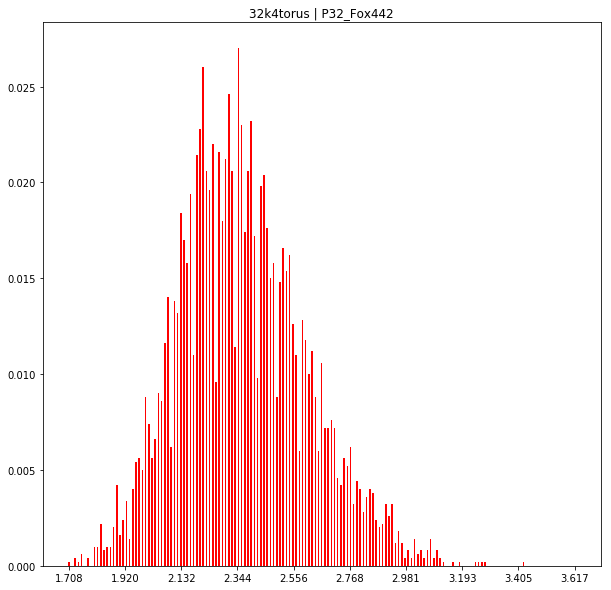

In [36]:
Fig1 = plt.figure(figsize=[10,10])
plt.bar(x=np.linspace(0,1,len(Height))*(max(Data1)-min(Data1)) + min(Data1),
        height=Height.astype('float32')/sum(Height),
        width = 0.006, align='center',color='r')
plt.xticks(np.linspace(min(Data1),max(Data1),10))
plt.title('%s | %s'%(Target_Topology,Alg_name))
plt.savefig('fig/%s_%s.png'%(Target_Topology,Alg_name))
plt.show()

# With Optimization

In [22]:
def get_RoutineTensor(file_path):
    global P
    Tensor = np.zeros([P,P,P],dtype = 'int16')
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        ind = 1
        for ele in line[2:]:
            Tensor[(int)(l)][(int)(r)][(int)(ele)] = ind
            ind += 1
    
    F.close()
    
    return Tensor

In [23]:
Unmap_Routine = Extract_cycles('../Simulator/BAMMA/%s.csv'%Alg_name)

In [24]:
Routint_Tensor = get_RoutineTensor('../Simulator/topology/%s_Static.srt'%Target_Topology)

In [25]:
def Get_Saturability_Seq(Route_Tensor, Comm_M, MAP):
    global P
    Ser = np.zeros(P,dtype='int16')
    i = 0
    for z in range(P):
        Ser[MAP[i]] = np.sum(Route_Tensor[:,:,z]*Comm_M)
        i += 1
    return Ser

In [26]:
def Annealing_Energy(Ser):
    return np.sum(np.square(Ser))

def accumulate_map(map1,rot_map):
    new_map = copy(map1)
    for ind,val in rot_map.items():
        new_map[ind] = copy(map1[val])
    return new_map

def get_rotmap_N(src,num=None):
    if num == None:
        num = len(src)
    sub_src = np.random.choice(src,size=num,replace=False)
    sub_tar = np.random.permutation(sub_src)
    res = {}
    for i in range(num):
        res[sub_src[i]] = sub_tar[i]
        
    return res

def sigmoid(x,Lambda=1):
    return 2.0/(1.0 + np.exp(-Lambda*x))

In [27]:

Data = []
ST = 0
for it in range(1000):
    min_Energy = 1e8
    TT = 0

    #search_dist = 0.1

    rand_series = np.random.permutation(np.arange(P))
    map_n = {i:rand_series[i] for i in range(P)}
    #Map_n = Get_Exchange(rand_map).astype('float32')
    step = 0
    while TT < 1000:
        # Get Random Map
        mov_map = get_rotmap_N(range(P),4)
        new_map = accumulate_map(map_n,mov_map)

        New_M = switch_nodes(Unmap_Routine,new_map)
        New_M = New_M/np.max(New_M)

        # Evaluate Energy
        Ser_Z = Get_Saturability_Seq(Routint_Tensor,New_M,new_map)
        En = Annealing_Energy(Ser_Z.astype('float32'))
        prob = sigmoid((float)(min_Energy-En)/min_Energy,1)
        if 0.9999 < prob:
            min_Energy = En
            map_n = new_map
            TT -= 1


        TT += 1
        step += 1
    ST += 1
    if ST%20 == 0:
        print(ST)
    T_Routine = get_BAMMA('../Simulator/BAMMA/%s.csv'%Alg_name,rank_map=map_n)
    m_time = get_Longest(Real_Routine(T_Routine,Adj))
    Data.append(m_time/(float)(ideal_time))

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000


# Distribution

In [31]:
Height,Left = np.histogram(Data,bins=np.arange(min(Data),max(Data),0.006))
print(len(Left))

108


In [32]:
Output_Raw_Stat('Raw/%s_%s_A.csv'%(Target_Topology,Alg_name),Data)

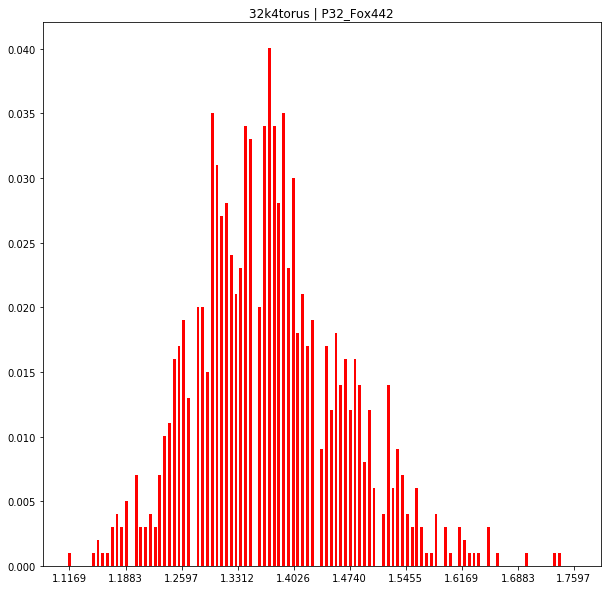

In [33]:
Fig1 = plt.figure(figsize=[10,10])
plt.bar(x=np.linspace(0,1,len(Height))*(max(Data)-min(Data)) + min(Data),
        height=Height.astype('float32')/sum(Height),
        width = 0.0036, align='center',color='r')
plt.xticks(np.linspace(min(Data),max(Data),10))
plt.title('%s | %s'%(Target_Topology,Alg_name))
plt.savefig('fig/%s_%s_A.png'%(Target_Topology,Alg_name))
plt.show()